In [1]:
import pandas as pd
dataset = pd.read_csv("../../Data/cleaned_v2.csv")
dataset

,Unnamed: 0,Link,Content,Content_cleaned_v1,Length_cleaned_v1,Content_cleaned_v2,Length_cleaned_v2,Label
0,0,https://baomoi.com/pep-guardiola-soi-mau-haala...,"Đến làm khách Everton, Haaland có bàn thắng th...",đến làm_khách everton haaland có bàn thắng thứ...,266,làm_khách everton haaland bàn thắng thứ ngoại_...,175.0,The thao
1,1,https://baomoi.com/mu-chieu-mo-hau-ve-da-nang-...,Mohamed Simakan là một trong những cầu thủ chơ...,mohamed simakan là một trong những cầu_thủ chơ...,199,mohamed simakan cầu_thủ chơi tốt rb leipzig mù...,124.0,The thao
2,2,https://baomoi.com/vet-gon-trong-chien-thang-c...,Barca để lại nhiều nỗi lo dù vừa lên ngôi tại...,barca để lại nhiều nỗi lo dù vừa lên_ngôi tại ...,715,barca nỗi lo dù vừa lên_ngôi la_liga ảnh reute...,503.0,The thao
3,3,https://baomoi.com/sao-man-city-chon-messi-gia...,Bernardo Silva đánh giá Haaland chưa đủ khả n...,bernardo_silva đánh_giá haaland chưa đủ khả_nă...,292,bernardo_silva đánh_giá haaland chưa đủ khả_nă...,210.0,The thao
4,4,https://baomoi.com/sea-games-32-dau-kiem-mang-...,"(Ảnh minh họa. Minh Quyết/TTXVN) Trưa 15/5, tạ...",ảnh minh_họa minh_quyết ttxvn trưa tại khu nhà...,235,ảnh minh_họa minh_quyết ttxvn trưa khu thi_đấu...,166.0,The thao
...,...,...,...,...,...,...,...,...
22182,22436,https://laodong.vn/van-hoa/chuan-bi-san-sang-c...,Sự kiện được tổ chức bởi Sở Văn hóa - Thể thao...,sự_kiện được tổ_chức bởi sở văn_hóa thể_thao v...,593,sự_kiện bởi sở văn_hóa thể_thao du_lịch thái_b...,193.0,Van hoa
22183,22437,https://laodong.vn/van-hoa/nhung-diem-ban-phao...,"Ngày 19.1 (28 Tết), UBND tỉnh Bình Dương cho b...",ngày tết ubnd tỉnh bình_dương cho biết các đơn...,323,tết ubnd tỉnh bình_dương đơn_vị sở ngành liên_...,618.0,Van hoa
22184,22438,https://laodong.vn/van-hoa/cuoc-doi-nsut-lam-t...,Sinh ra và lớn lên trong gia đình có 4 chị em ...,sinh ra và lớn lên trong gia_đình có chị_em tạ...,621,sinh lớn gia_đình chị_em vùng_đất sen hồng đồn...,353.0,Van hoa
22185,22439,https://laodong.vn/van-hoa-giai-tri/long-con-x...,Các ông đồ ngày nay tha hồ múa bút và cũng kiế...,các ông đồ ngày_nay tha_hồ múa bút và cũng kiế...,229,đồ ngày_nay tha_hồ múa bút kiếm tiền bán chữ đ...,419.0,Van hoa


In [99]:
dataset['Content_cleaned_v2'].iloc[1]

'mohamed simakan cầu_thủ chơi tốt rb leipzig mùa giải nay ngôi_sao tuổi mẫu cầu_thủ đa_năng đá tiền_vệ lệch hậu_vệ chơi vị_trí trung_vệ đều tốt cầu_thủ chơi bundesliga tốc_độ khả_năng hỗ_trợ tấn_công tốt simakan trực_tiếp ghi bàn kiến_tạo đầu mùa giải màn trình_diễn ấn_tượng nhận quan_tâm đội bóng lớn mu xem_xét khả_năng chuyển_nhượng hậu_vệ mohamed simakan blđ mu xem_xét khả_năng chuyển_nhượng mohamed_simakan mùa hè chiều sâu đội_hình chính đa_năng simakan yếu_tố erik ten hag cân_nhắc bổ_sung đội_hình mu_hướng mùa giải mu cạnh_tranh arsenal tottenham thương_vụ rb leipzig đồng_ý bán ngôi_sao triệu euro phía simakan phát_biểu mới_đây thừa_nhận hạnh_phúc clb tương_lai phụ_thuộc hoàn_toàn rb leipzig aaron_wan bissaka harry_maguire rời mu dọn đường quỷ đỏ đón mohamed_simakan psg quan_tâm trung_vệ crystal_palace sẵn_sàng mua wan bissaka thể_thao văn_hóa'

In [44]:
from gensim.models import Word2Vec, KeyedVectors
# w2v = Word2Vec.load("../../FeatureEngineering/Vectorize/w2v_256_skip_cleaned_v2_v2.model")
w2v = KeyedVectors.load_word2vec_format("../../baomoi/data/baomoi.window2.vn.model.bin.gz", binary=True)

In [70]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing import sequence
from keras_preprocessing.sequence import pad_sequences

import numpy as np

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
# label_tokenizer = Tokenizer()
# label_tokenizer.fit_on_texts(dataset["Label"])
# token_label_seq = np.array(label_tokenizer.texts_to_sequences(dataset['Label']))
tokenizer.fit_on_texts(dataset['Content_cleaned_v1'])
sequences = tokenizer.texts_to_sequences(dataset['Content_cleaned_v1'])

maxlen = 500
X = sequence.pad_sequences(sequences, maxlen=maxlen)
Y = pd.get_dummies(dataset['Label'])

In [46]:
Y

,Chinh tri,Giai tri,Giao duc,Khoa hoc,Kinh te,Phap luat,Suc khoe,The thao,Van hoa
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
22182,0,0,0,0,0,0,0,0,1
22183,0,0,0,0,0,0,0,0,1
22184,0,0,0,0,0,0,0,0,1
22185,0,0,0,0,0,0,0,0,1


In [71]:
import numpy as np
notin = []
embedding_dim = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
print('num_words:', num_words)
for word, i in word_index.items():
    if word in w2v.key_to_index:
            embedding_matrix[i] = w2v[word]
    else:
        notin.append(word)

num_words: 109917


In [74]:
len([i for i in embedding_matrix if np.mean(i) != 0]), len(notin)

(59890, 50026)

In [85]:
two = []
one = []
more = []
for i in notin:
  leng = len(i.split('_'))
  if leng == 2:
    two.append(i)
    continue
  if leng == 1:
    one.append(i)
    continue
  more.append(i)

In [86]:
len(one), len(two), len(more)

(15805, 21437, 12784)

In [96]:
"|".join(more)

'hoạt_động_kinh_doanh|đông_nam_á|đảm_bảo_an_toàn|bắt_đầu_từ|vi_phạm_pháp_luật|hoạt_động_sản_xuất|có_nghĩa_là|đoàn_thể_thao|đông_nam_bộ|phó_cục_trưởng|phi_vật_thể|công_ty_con|phó_chủ_nhiệm|tái_cơ_cấu|bồ_đào_nha|đảm_bảo_an_ninh|kết_quả_thực_hiện|phát_huy_hiệu_quả|tình_hình_thế_giới|điện_biên_phủ|tái_cấu_trúc|đàm_vĩnh_hưng|thực_hiện_hành_vi|tổng_diện_tích|trên_cơ_thể|thái_thiên_phượng|tổng_dư_nợ|nhu_cầu_tiêu_thụ|ban_hành_văn_bản|ban_hành_quyết_định|hạ_lãi_suất|tập_trung_thực_hiện|võ_thị_ánh_xuân|trường_hợp_tử_vong|phó_vụ_trưởng|tổng_chỉ_tiêu|vũ_đức_đam|chính_phủ_phê_duyệt|sản_phẩm_chất_lượng|phó_thống_đốc|tôn_đức_thắng|đoàn_thanh_niên|phó_viện_trưởng|đinh_tiến_dũng|vũ_ngọc_đãng|phó_trưởng_phòng|quản_lý_tài_sản|tổng_trị_giá|tổng_khối_lượng|chính_đề_nghị|viện_vệ_sinh|bắc_trung_bộ|đặng_thùy_trang|qua_mặt_nạ|ấn_độ_dương|đào_minh_tú|đinh_phương_thành|sa_sút_trí_tuệ|quản_lý_tài_chính|luật_đấu_thầu|thẩm_định_giá|phiên_đấu_giá|tham_gia_bảo_hiểm|cát_vạn_lợi|vùng_biên_giới|phi_truyền_thống|ký_kết_h

In [64]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional, Dropout

model1 = Sequential()
model1.add(Embedding(num_words, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model1.add(Bidirectional(LSTM(units=300, return_sequences= False)))
model1.add(Dropout(0.2))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dense(units=68, activation='relu'))
model1.add(Dense(9, activation='softmax'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 450, 300)          18332100  
                                                                 
 bidirectional_4 (Bidirectio  (None, 600)              1442400   
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 600)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               153856    
                                                                 
 dense_12 (Dense)            (None, 68)                17476     
                                                                 
 dense_13 (Dense)            (None, 9)                 621       
                                                      

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size= 0.3, random_state= 42)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((15530, 450), (15530, 9), (6657, 450), (6657, 9))

In [12]:
# from keras.callbacks import EarlyStopping
# callback1 = EarlyStopping(monitor = "val_accuracy", patience= 4)
# callback2 = EarlyStopping(monitor = "val_loss", patience= 4)

In [66]:
model1.fit(X_train, Y_train, validation_split=0.1, epochs= 20) 

Epoch 1/20
437/437 [==============================] - 1067s 2s/step - loss: 0.1186 - accuracy: 0.8092 - val_loss: 0.0838 - val_accuracy: 0.8686
Epoch 2/20
437/437 [==============================] - 1842s 4s/step - loss: 0.0701 - accuracy: 0.8861 - val_loss: 0.0749 - val_accuracy: 0.8738
Epoch 3/20
437/437 [==============================] - 1789s 4s/step - loss: 0.0596 - accuracy: 0.9021 - val_loss: 0.0725 - val_accuracy: 0.8841
Epoch 4/20
437/437 [==============================] - 1300s 3s/step - loss: 0.0445 - accuracy: 0.9280 - val_loss: 0.0621 - val_accuracy: 0.9053
Epoch 5/20
437/437 [==============================] - 1285s 3s/step - loss: 0.0359 - accuracy: 0.9415 - val_loss: 0.0659 - val_accuracy: 0.9034
Epoch 6/20
437/437 [==============================] - 1227s 3s/step - loss: 0.0282 - accuracy: 0.9539 - val_loss: 0.0737 - val_accuracy: 0.8925
Epoch 7/20
 78/437 [====>.........................] - ETA: 14:21 - loss: 0.0183 - accuracy: 0.9683

KeyboardInterrupt: 

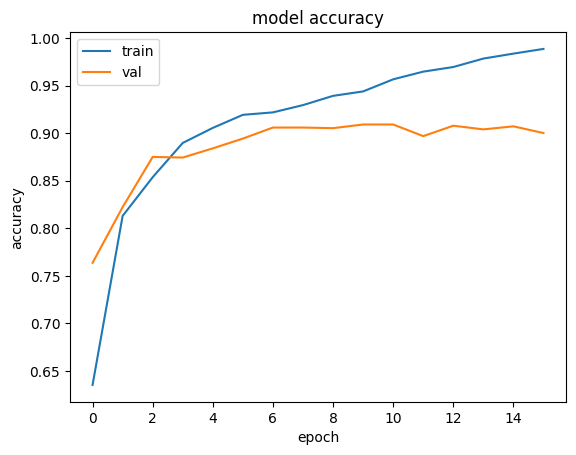

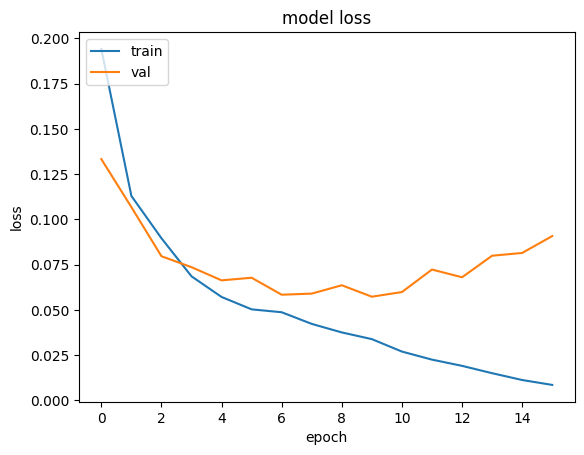

In [14]:
from matplotlib import pyplot as plt
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
from matplotlib import pyplot as plt
plt.plot(model1.history.history['loss'])
plt.plot(model1.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
loss, accuracy = model1.evaluate(X_test, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

209/209 [==============================] - 62s 298ms/step - loss: 0.0865 - accuracy: 0.9090
Test Loss: 0.0865267887711525
Test Accuracy: 0.9089680314064026


In [16]:
y_pred = model1.predict(X_test)

209/209 [==============================] - 68s 318ms/step


In [18]:
predicted = y_pred.argmax(axis=1)

In [19]:
true_labels = Y_test.values.argmax(axis=1)

In [20]:
true_labels

array([0, 2, 1, ..., 6, 4, 2])

In [21]:
predicted

array([0, 2, 1, ..., 6, 4, 2])

In [22]:
arr_wrong = []
for i, v in enumerate(predicted):
  if v != true_labels[i]:
    arr_wrong.append(i)

In [23]:
arr_true = []
for i, v in enumerate(predicted):
  if v == true_labels[i]:
    arr_true.append(i)

In [28]:
w = tokenizer.sequences_to_texts(predicted[arr_wrong])

TypeError: 'numpy.int64' object is not iterable

In [27]:
t = tokenizer.sequences_to_texts(true_labels[arr_true])

TypeError: 'numpy.int64' object is not iterable

In [ ]:
length_w = pd.Series(sorted([len(l.split()) for l in w]))

In [ ]:
length_t = pd.Series(sorted([len(l.split()) for l in t]))

In [ ]:
len(length_w)

202

In [ ]:
len(length_t)

139

<AxesSubplot:>

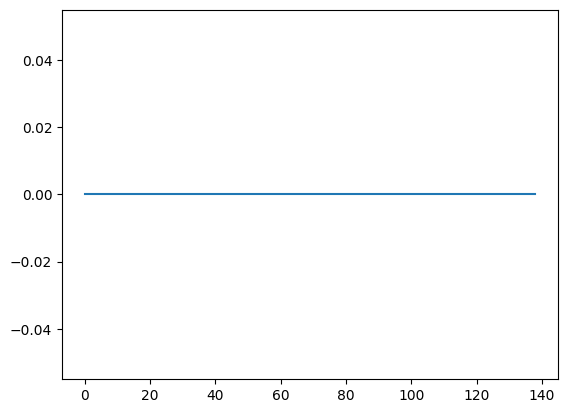

In [ ]:
length_t.plot()

<AxesSubplot:>

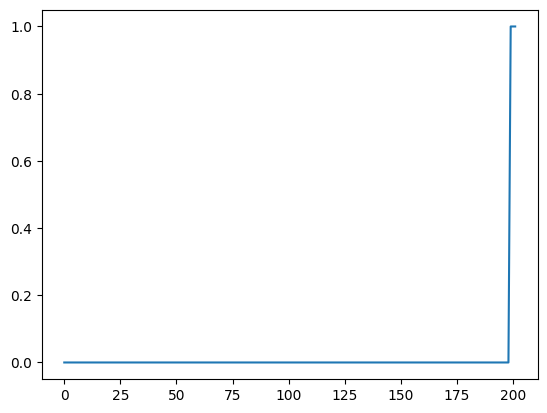

In [ ]:
length_w.plot()

In [ ]:
len(length_w[length_w.values < 50])

25

In [ ]:
len(length_t[length_t.values < 50])

207

In [ ]:
y_pred[arr_wrong]

array([[6.4051792e-02, 6.9254806e-05, 9.2364273e-05, 4.1919047e-05,
        9.3566120e-01, 8.3380692e-05],
       [1.2784341e-03, 9.5727695e-03, 5.4319197e-04, 9.4827020e-01,
        1.7692205e-02, 2.2643127e-02],
       [9.4465585e-03, 4.1561842e-02, 9.4781786e-01, 3.0632486e-04,
        3.5039257e-04, 5.1707233e-04],
       ...,
       [1.2916939e-04, 8.7214418e-04, 3.0277224e-04, 6.8369714e-06,
        9.9866176e-01, 2.7242670e-05],
       [1.1055357e-03, 9.6837413e-01, 1.1810916e-04, 1.5293632e-04,
        3.0194249e-02, 5.4966207e-05],
       [1.4401269e-01, 8.3725637e-01, 4.5833602e-03, 3.4597664e-04,
        1.2222120e-02, 1.5795223e-03]], dtype=float32)

In [ ]:
predicted[arr_wrong]

array([4, 3, 2, 5, 1, 0, 4, 1, 4, 5, 1, 1, 2, 3, 0, 4, 0, 1, 5, 1, 4, 4,
       4, 0, 1, 4, 5, 4, 5, 4, 4, 4, 5, 1, 0, 2, 3, 1, 0, 0, 3, 4, 5, 4,
       4, 2, 5, 0, 4, 0, 4, 5, 2, 4, 2, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 2, 5, 1, 0, 1, 1, 1, 4, 1, 1, 4, 0, 4, 1, 3, 2, 5, 2, 1, 0, 1,
       1, 0, 4, 2, 4, 4, 1, 5, 4, 0, 0, 1, 2, 4, 1, 0, 2, 1, 0, 4, 2, 4,
       0, 0, 0, 4, 0, 4, 4, 1, 4, 0, 0, 0, 0, 5, 4, 0, 0, 3, 4, 2, 4, 0,
       4, 0, 5, 1, 4, 1, 0, 0, 4, 4, 2, 0, 1, 4, 5, 4, 0, 4, 4, 0, 2, 1,
       1, 4, 1, 0, 1, 0, 1, 0, 4, 1, 2, 1, 2, 4, 2, 0, 1, 0, 5, 2, 2, 0,
       5, 2, 1, 1, 3, 0, 2, 1, 5, 0, 4, 0, 4, 0, 4, 0, 1, 1, 2, 3, 2, 5,
       3, 0, 0, 2, 1, 4, 0, 1, 4, 0, 4, 4, 1, 1, 4, 1, 1, 2, 2, 1, 0, 4,
       4, 0, 4, 0, 2, 0, 2, 0, 5, 4, 4, 1, 4, 1, 3, 4, 4, 5, 4, 3, 4, 1,
       0, 4, 5, 0, 4, 1, 0, 0, 0, 5, 0, 5, 5, 0, 0, 4, 0, 5, 0, 2, 1, 1,
       5, 3, 5, 4, 4, 0, 4, 2, 4, 4, 1, 4, 4, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       2, 1, 1, 4, 4, 4, 2, 1, 4, 0, 0, 1, 1, 1, 4,

In [ ]:
true_labels[arr_wrong]

array([0, 4, 0, 4, 4, 4, 0, 2, 0, 3, 3, 3, 5, 4, 3, 1, 1, 3, 2, 3, 0, 0,
       1, 1, 0, 1, 1, 0, 3, 0, 0, 1, 3, 0, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       0, 4, 3, 4, 5, 4, 2, 2, 4, 3, 1, 4, 4, 4, 4, 4, 4, 0, 4, 4, 1, 0,
       1, 4, 3, 3, 4, 2, 4, 4, 1, 4, 5, 3, 3, 3, 3, 1, 1, 3, 3, 2, 3, 5,
       0, 4, 1, 1, 1, 2, 0, 0, 0, 4, 1, 0, 0, 0, 0, 4, 0, 5, 4, 0, 0, 1,
       3, 4, 4, 1, 4, 0, 1, 0, 1, 3, 2, 4, 4, 2, 0, 4, 4, 1, 1, 4, 0, 3,
       5, 4, 3, 3, 0, 4, 4, 4, 0, 0, 0, 4, 3, 3, 3, 0, 4, 2, 0, 4, 1, 4,
       3, 0, 0, 4, 4, 4, 5, 4, 5, 0, 3, 3, 4, 1, 4, 4, 4, 4, 1, 1, 4, 4,
       3, 4, 4, 4, 0, 4, 5, 4, 2, 4, 3, 4, 5, 3, 0, 4, 0, 3, 1, 4, 4, 3,
       1, 4, 4, 1, 4, 3, 4, 4, 3, 4, 1, 0, 2, 3, 3, 2, 0, 1, 5, 3, 4, 0,
       1, 4, 0, 4, 4, 3, 1, 4, 4, 3, 3, 3, 2, 4, 1, 0, 1, 3, 0, 1, 2, 3,
       4, 3, 0, 1, 3, 3, 4, 4, 4, 1, 4, 1, 0, 1, 4, 2, 4, 2, 4, 4, 2, 3,
       3, 4, 1, 0, 1, 4, 0, 4, 1, 1, 0, 0, 0, 1, 0, 3, 4, 3, 4, 3, 4, 3,
       1, 2, 4, 0, 3, 2, 3, 3, 3, 4, 4, 2, 4, 3, 0,

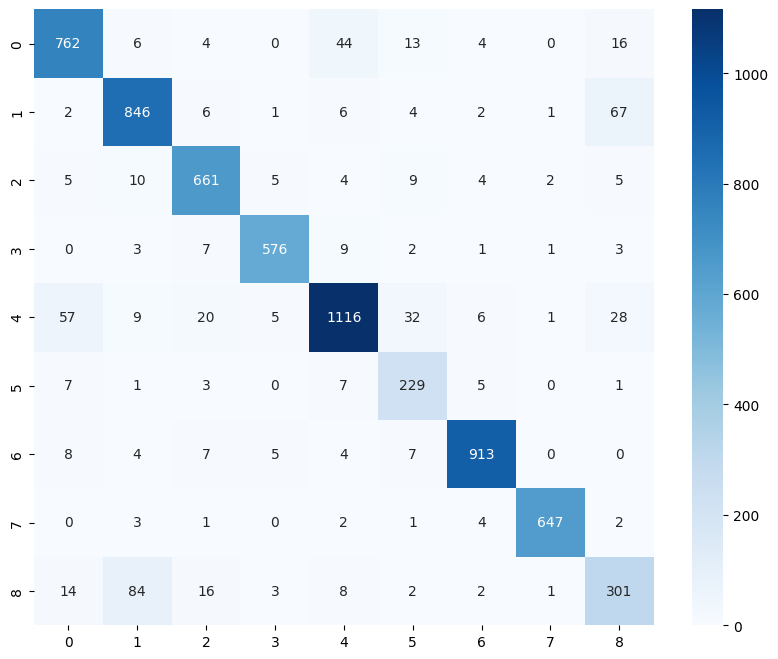

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def heatconmat(y_pred, y_test):
  plt.figure(figsize=(10,8))
  cnf_matrix = confusion_matrix(y_pred, y_test)
  ax = sns.heatmap(cnf_matrix, annot=True, fmt='', cmap='Blues')
  ax.xaxis.set_ticklabels(list(set(data[])))
  ax.yaxis.set_ticklabels(list(set(y_test)))
  plt.show()
heatconmat(predicted, true_labels)

In [ ]:
check = pd.read_csv("../MachineLearning/.svm_predict.csv")
se_check = tokenizer.texts_to_sequences(check['content'])

maxlen = 300
x_check = sequence.pad_sequences(se_check, maxlen=maxlen)

In [ ]:
check_pred = model1.predict(x_check)

11/11 [==============================] - 3s 277ms/step


In [ ]:
Y.columns

Index(['business', 'education', 'entertainment', 'health', 'politics',
       'sport'],
      dtype='object')

In [ ]:
arr_wrong[40:50], check_pred[arr_wrong][40:50]

([92, 93, 94, 97, 98, 101, 102, 103, 104, 106],
 array([[2.62556851e-01, 6.25342488e-01, 3.25304177e-03, 8.25964671e-04,
         1.05276950e-01, 2.74469145e-03],
        [7.11916760e-02, 6.04363322e-01, 3.75171984e-03, 9.72234877e-04,
         3.04071844e-01, 1.56490859e-02],
        [1.74123734e-01, 7.32532799e-01, 1.64917409e-02, 2.49359626e-02,
         4.48096730e-02, 7.10622407e-03],
        [4.52463925e-01, 7.99309183e-03, 4.70156819e-02, 5.68003953e-03,
         1.72118389e-03, 4.85126078e-01],
        [2.41072655e-07, 1.32555627e-07, 1.56743720e-08, 1.30736993e-07,
         1.15347973e-06, 9.99998331e-01],
        [1.28814038e-02, 3.66701894e-02, 1.11860156e-01, 2.27564812e-01,
         6.07512355e-01, 3.51108611e-03],
        [1.65444857e-04, 8.23466962e-07, 9.68766813e-07, 1.13476482e-07,
         9.99832511e-01, 1.71598003e-07],
        [1.20254776e-06, 1.64318340e-06, 5.61783509e-06, 2.89066904e-08,
         9.99991536e-01, 5.76640780e-08],
        [8.12001646e-01, 7.10842

In [ ]:
check_test = pd.get_dummies(check['true label'])

In [ ]:
model1.evaluate(x_check, test_check)

11/11 [==============================] - 3s 287ms/step - loss: 0.4570 - accuracy: 0.5543


[0.4570435881614685, 0.5542522072792053]